In [8]:
%matplotlib inline

import sys
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import copy

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from lib.utils import get_camera_intrinsics, get_camera_extrinsics
from lib.planar_patch_detector import PlanarPatchDetector
from lib.masked_yolo_detector import MaskedYOLODetector
from lib.box_pose_estimator import BoxPoseEstimator

In [9]:
# Load depth image
depth_path = "../data/medium_box/raw_depth.png"
depth_image = cv.imread(depth_path, cv.IMREAD_ANYDEPTH)

if depth_image is None:
    raise FileNotFoundError(f"Failed to load depth image from {depth_path}")

# read camera intrinsics
camera_intrinsics = get_camera_intrinsics("../data/small_box/intrinsics.json")
camera_extrinsics = get_camera_extrinsics("../data/small_box/cam2root.json")




0: 480x640 4 medium_boxs, 19 small_boxs, 1352.8ms
Speed: 58.4ms preprocess, 1352.8ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)


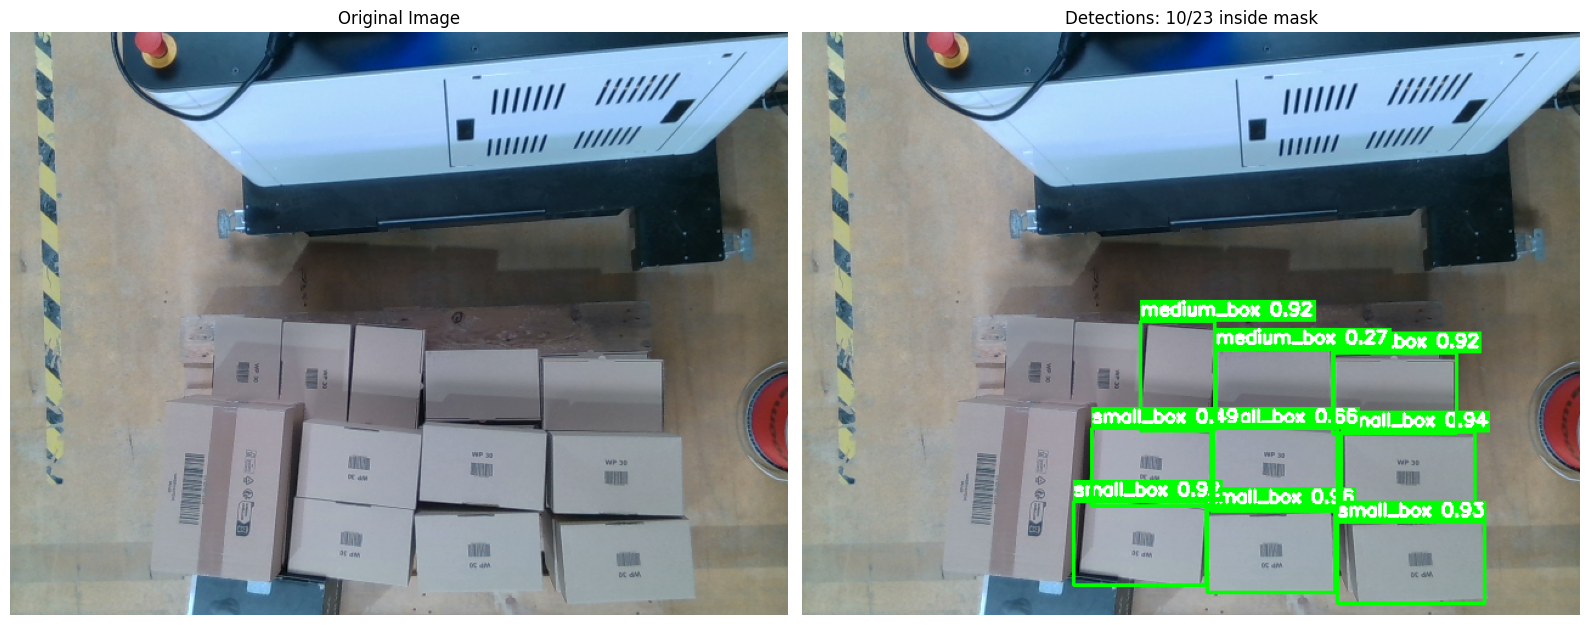

Found 10 boxes inside the mask:
Class: small_box, Confidence: 0.96, Box: (333, 392, 438, 461)
Class: small_box, Confidence: 0.94, Box: (443, 329, 553, 399)
Class: small_box, Confidence: 0.93, Box: (440, 403, 561, 470)
Class: small_box, Confidence: 0.92, Box: (223, 386, 332, 455)
Class: medium_box, Confidence: 0.92, Box: (278, 238, 339, 328)
Class: small_box, Confidence: 0.92, Box: (436, 264, 538, 330)
Class: small_box, Confidence: 0.66, Box: (336, 326, 440, 394)
Class: small_box, Confidence: 0.49, Box: (238, 326, 338, 390)
Class: small_box, Confidence: 0.30, Box: (340, 261, 436, 324)
Class: medium_box, Confidence: 0.27, Box: (340, 261, 437, 323)

Detailed mask overlap analysis:
small_box: 0.96 - Mask overlap: 100.00%
small_box: 0.94 - Mask overlap: 100.00%
small_box: 0.93 - Mask overlap: 100.00%
small_box: 0.92 - Mask overlap: 100.00%
medium_box: 0.92 - Mask overlap: 100.00%
small_box: 0.92 - Mask overlap: 100.00%
small_box: 0.66 - Mask overlap: 100.00%
small_box: 0.49 - Mask overlap: 

In [10]:
# run masked yolo detector
color_image = cv.imread("../data/small_box/color_image.png")
depth_image = cv.imread("../data/small_box/raw_depth.png", cv.IMREAD_ANYDEPTH)

yolo_detector = MaskedYOLODetector(
        color_image=color_image,
        depth_image=depth_image,
        model_path="/workspace/data/model/best.pt"
    )
yolo_detector.set_box_area(min_area=2000, max_area=10000)
yolo_detector.create_mask()
boxes = yolo_detector.run_detection(visualize=True)
yolo_detector.print_box_details()

In [11]:
print(boxes)

[('small_box', 0.9647466540336609, (333, 392, 438, 461)), ('small_box', 0.9398967623710632, (443, 329, 553, 399)), ('small_box', 0.93170565366745, (440, 403, 561, 470)), ('small_box', 0.9236579537391663, (223, 386, 332, 455)), ('medium_box', 0.919619083404541, (278, 238, 339, 328)), ('small_box', 0.9191368222236633, (436, 264, 538, 330)), ('small_box', 0.6579309105873108, (336, 326, 440, 394)), ('small_box', 0.4872472286224365, (238, 326, 338, 390)), ('small_box', 0.30067601799964905, (340, 261, 436, 324)), ('medium_box', 0.2713591456413269, (340, 261, 437, 323))]


In [12]:
known_dims = {
        'small_box': [0.340, 0.250, 0.095],
        'medium_box': [0.255, 0.155, 0.100]
    }

# run planar patch detector
planar_detector = PlanarPatchDetector(
    color_img=color_image,
    depth_img=depth_image,
    intrinsics=camera_intrinsics,
    known_dims=known_dims
)

planar_detector.set_yolo_detections(boxes)
planar_detector.process_all(
    visualize=False,
    visualize_individual=False,
    mode='2d',
    normal_variance_threshold_deg=60,
    coplanarity_deg=60,
    min_plane_edge_length=0.03,
    min_num_points=20,
    knn=50,
    voxel_size=0.01,  # Change voxel size
    distance_threshold=0.005,  # Change the RANSAC distance threshold
    nb_neighbors=30,  # Change number of neighbors for outlier removal
    std_ratio=1.5, # Adjust standard deviation ratio for outlier removal
    min_plane_area=0.00003  # Minimum area of the detected plane
)

results = planar_detector.get_results()
surfaces = planar_detector.get_cleaned_surfaces()


 Detection 0 (class: small_box) - found 2 planar patches
   - Patch 0: normal=[  -0.058676    0.012597     -0.9982], alignment_score=0.650, inliers=4
   - Patch 1: normal=[    0.88819     0.12863     -0.4411], alignment_score=1.064, inliers=0
No valid patches left after filtering (small planes).

 Detection 1 (class: small_box) - found 2 planar patches
   - Patch 0: normal=[    0.50096   -0.099096    -0.85978], alignment_score=0.338, inliers=3
   - Patch 1: normal=[  -0.022768       -0.37    -0.92875], alignment_score=0.922, inliers=2
No valid patches left after filtering (small planes).

 Detection 2 (class: small_box) - found 4 planar patches
   - Patch 0: normal=[   -0.23718     0.77502    -0.58574], alignment_score=0.509, inliers=0
   - Patch 1: normal=[    0.90742 -0.00016927    -0.42023], alignment_score=0.814, inliers=3
   - Patch 2: normal=[    0.42331   -0.041394    -0.90504], alignment_score=0.340, inliers=2
   - Patch 3: normal=[   -0.11066   -0.013242    -0.99377], alignme

In [13]:
print(surfaces)

[{'class': 'small_box', 'points': PointCloud with 490 points.}, {'class': 'small_box', 'points': PointCloud with 423 points.}, {'class': 'small_box', 'points': PointCloud with 379 points.}, {'class': 'small_box', 'points': PointCloud with 560 points.}, {'class': 'medium_box', 'points': PointCloud with 405 points.}, {'class': 'small_box', 'points': PointCloud with 432 points.}, {'class': 'small_box', 'points': PointCloud with 530 points.}, {'class': 'small_box', 'points': PointCloud with 561 points.}, {'class': 'small_box', 'points': PointCloud with 470 points.}, {'class': 'medium_box', 'points': PointCloud with 454 points.}]


In [ ]:
pose_estimator = BoxPoseEstimator(
    intrinsics=camera_intrinsics,
    extrinsics=camera_extrinsics,
    known_dims=known_dims
)

patch_list = []
for patches, (cls, _, _) in zip(planar_detector.per_box_patches, boxes):
    if patches:  # only if detection has patches
        patch_list.append({
            "points": patches[0],  # pick best (1st) patch
            "class": cls
        })

pose_estimator.estimate_from_all(patch_list)
pose_estimator.print_poses()
pcd_camera = planar_detector.get_full_scene_pcd()
pcd_world = copy.deepcopy(pcd_camera)
pcd_world.transform(camera_extrinsics)

pose_estimator.visualize_poses(image=color_image, pointcloud=pcd_world, colorize_pc_with_image=True)




Box 0 (small_box) - face: front
  Position: [   -0.21237      1.0887    -0.46012]
  Rotation matrix:
[[    0.14629   -0.054063     0.98776]
 [   0.051557    -0.99673   -0.062189]
 [     0.9879    0.060023    -0.14302]]
  Dimensions: [0.34, 0.25, 0.095]

Box 1 (small_box) - face: side
  Position: [   -0.87106      1.0323    -0.79751]
  Rotation matrix:
[[  -0.037871    -0.42984    -0.90211]
 [   -0.99831   -0.023512    0.053112]
 [   -0.04404      0.9026    -0.42822]]
  Dimensions: [0.34, 0.25, 0.095]

Box 2 (small_box) - face: side
  Position: [   -0.42969      1.3004    -0.71558]
  Rotation matrix:
[[   -0.78771     0.34214     -0.5123]
 [  -0.066322     0.77967     0.62267]
 [    0.61246     0.52446    -0.59146]]
  Dimensions: [0.34, 0.25, 0.095]

Box 3 (small_box) - face: side
  Position: [     0.1964      1.0344    -0.47492]
  Rotation matrix:
[[    -0.1407    -0.93558    -0.32389]
 [   -0.98716     0.15754   -0.026237]
 [    0.07557     0.31604    -0.94573]]
  Dimensions: [0.34, 0